# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [20]:
import pandas as pd
import numpy as np

from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
import plotnine as p9


In [21]:
penguins = load_penguins()
print(penguins.head())


  species     island  bill_length_mm  ...  body_mass_g     sex  year
0  Adelie  Torgersen            39.1  ...       3750.0    male  2007
1  Adelie  Torgersen            39.5  ...       3800.0  female  2007
2  Adelie  Torgersen            40.3  ...       3250.0  female  2007
3  Adelie  Torgersen             NaN  ...          NaN     NaN  2007
4  Adelie  Torgersen            36.7  ...       3450.0  female  2007

[5 rows x 8 columns]


In [22]:
penguins_clean = penguins.dropna()


In [23]:
X = penguins_clean.drop('species', axis=1)
y = penguins_clean['species']

In [24]:
X_dummified = pd.get_dummies(X, columns=['island', 'sex'], drop_first=True)


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dummified, y, test_size=0.25)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
models = {
    "kNN (K=3)": KNeighborsClassifier(n_neighbors=3),
    "kNN (K=10)": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree (alpha = 0.5)": DecisionTreeClassifier(ccp_alpha = 0.5),
    "Decision Tree (alpha = 2)": DecisionTreeClassifier(ccp_alpha = 2)
}

model_results = {}


In [28]:
for name, model in models.items():
    print(f"--- Evaluating Model: {name} ---")
    
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # --- Evaluation Metrics ---
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    print("Confusion Matrix:")
    print(cm)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#     disp.plot() 
#     plt.title(f"Confusion Matrix for {name}") 
#     plt.show()
    # 2. Classification Report (Accuracy, Precision, Recall, F1-score)
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    
    # 3. AUC Score (One-vs-Rest for multi-class)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"Multi-class AUC (One-vs-Rest): {auc:.4f}\n")
    
    # Store probabilities for ROC plot later
    model_results[name] = {
        'model': model,
        'y_pred_proba': y_pred_proba
    }


--- Evaluating Model: kNN (K=3) ---
Confusion Matrix:
[[29  0  0]
 [ 1 19  0]
 [ 0  0 35]]
Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        29
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       1.00      1.00      1.00        35

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.99        84
weighted avg       0.99      0.99      0.99        84

Multi-class AUC (One-vs-Rest): 0.9998

--- Evaluating Model: kNN (K=10) ---
Confusion Matrix:
[[29  0  0]
 [ 0 20  0]
 [ 0  0 35]]
Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        20
      Gentoo       1.00      1.00      1.00        35

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00  

C:\Users\navsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\navsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\navsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\navsa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and be

In [40]:
positive_class = 'Adelie'

roc_rows = []
for name, results in model_results.items():
    model_classes = list(results['model'].classes_)
    if positive_class not in model_classes:
        continue
    pos_idx = model_classes.index(positive_class)

    y_true_bin = (y_test == positive_class).astype(int).values
    y_score = results['y_pred_proba'][:, pos_idx]

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)

    roc_rows += [
        {"fpr": f, "tpr": t, "model": name}
        for f, t in zip(fpr, tpr)
    ]

roc_df = pd.DataFrame(roc_rows)

# --- Plot with plotnine (ggplot-style) ---
p = (
    p9.ggplot(roc_df, p9.aes(x="fpr", y="tpr", color="model"))
    + p9.geom_line()
#     + p9.geom_abline(slope=1, intercept=0, linetype="dashed")
#     + p9.coord_equal()  # square plotting area
#     + p9.scale_x_continuous(limits=(0, 1))
#     + p9.scale_y_continuous(limits=(0, 1))
    + p9.labs(
        title=f"ROC Curves for Predicting '{positive_class}' Species",
        x="False Positive Rate",
        y="True Positive Rate",
        color="Model"
    )
    + p9.theme(legend_position="right")
)


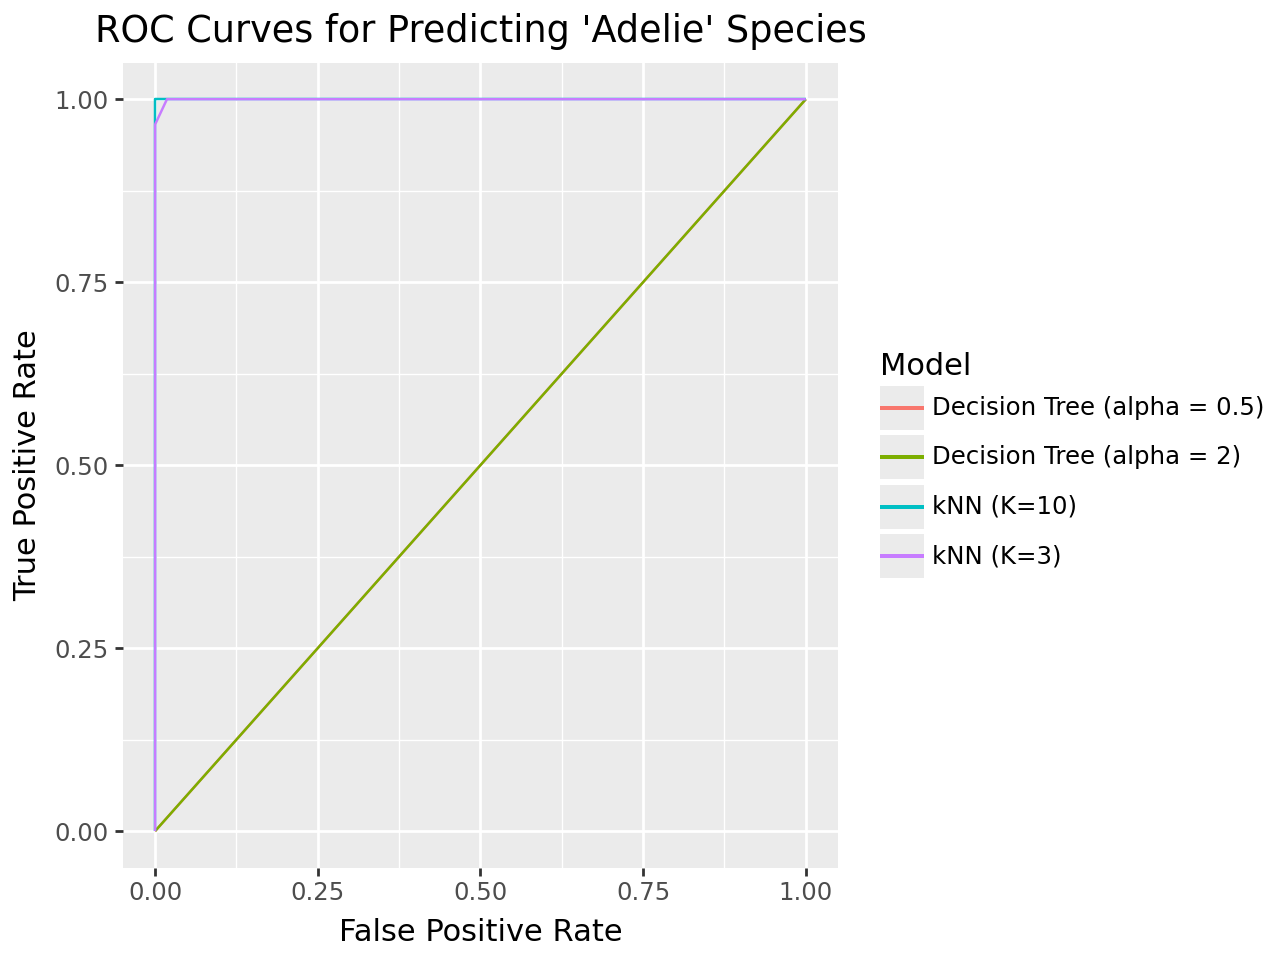

In [41]:
p.show()